# Outlier detection

Будем использовать библиотеку pyod (pip install pyod)

In [4]:
!pip install pyod
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42026 sha256=152485f4f6c56caf23c9a32f74b0bae35a52c76867f43977300b20d292be86db
  Stored in directory: /Users/irsafilo/Library/Caches/pip/wheels/40/d4/93/ea2224f96bd2868538da3b8231211c42632221600b080ddf16
Successfully built combo


In [14]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

### Сгенерируем набор точек для задачи поиска выбросов

Populating the interactive namespace from numpy and matplotlib


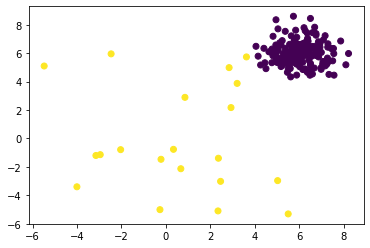

In [15]:
from pyod.utils.data import generate_data
from matplotlib import pylab as plt
%pylab inline

contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, y_train, X_test, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=2,
                  contamination=0.1,
                  random_state=42)

plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

### Применим KNN для нахождения выбросов

In [16]:
from pyod.models.knn import KNN   # kNN detector

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

### Посмотрим на качество алгоритма

In [17]:
from pyod.utils.data import evaluate_print

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.9992, precision @ rank n:0.95

On Test Data:
KNN ROC:1.0, precision @ rank n:1.0


### Визуализируем результат

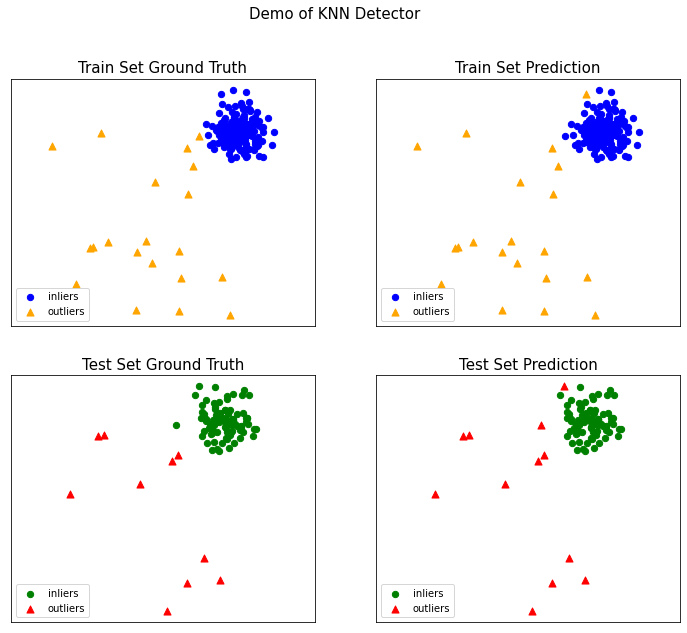

In [18]:
from pyod.utils.example import visualize
    
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

### Сравним различные алгоритмы для нахождения выбросов по времени работы и качеству

Загрузим данные и информацию о проценте выбросов

In [19]:
mat_file = 'arrhythmia.mat'

random_state = np.random.RandomState(42)

df_columns = ['Characteristics', 'Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'ABOD', 'CBLOF', 'FB', 'HBOS', 'IForest', 'KNN', 'LOF', 'MCD',
              'OCSVM', 'PCA']

mat = loadmat(mat_file)

X = mat['X']
y = mat['y'].ravel()
outliers_fraction = np.count_nonzero(y) / len(y)
outliers_percentage = round(outliers_fraction * 100, ndigits=4)

# construct containers for saving results
roc_list = ['ROC-AUC',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
prn_list = ['Precision@N',mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
time_list = ['Time', mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

Разобъем данные на тренировочную и валидационную части и масштабируем их.

In [21]:
# 60% data for training and 40% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=random_state)

# standardizing data for processing
X_train_norm, X_test_norm = standardizer(X_train, X_test)

Применим различные алгоритмы нахождения выбросов

In [22]:
from time import time

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                     random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    t0 = time()
    #обучите алгоритм clf на X_train_norm
    clf.fit(X_train_norm)
    #test_scores = сделайте предсказание (decision_function) на X_test_norm
    test_scores = clf.decision_function(X_test_norm) #аналог predict_proba
    t1 = time()
    duration = round(t1 - t0, ndigits=4)
    time_list.append(duration)

    #вычислите roc_auc_score и precision_n_scores для тестовых данных (y_test, test_scores)
    roc = roc_auc_score(y_test, test_scores)
    prn = precision_n_scores(y_test, test_scores)

    print('{clf_name} ROC:{roc}, precision @ rank n:{prn}, '
          'execution time: {duration}s'.format(
        clf_name=clf_name, roc=roc, prn=prn, duration=duration))

    roc_list.append(roc)
    prn_list.append(prn)
    

df_time = pd.DataFrame([time_list],columns=df_columns)
df_roc = pd.DataFrame([roc_list],columns=df_columns)
df_prn = pd.DataFrame([prn_list],columns=df_columns)

df_res = pd.concat([df_time, df_roc, df_prn], axis=0)

Angle-based Outlier Detector (ABOD) ROC:0.7923657718120806, precision @ rank n:0.46875, execution time: 0.1258s
Cluster-based Local Outlier Factor ROC:0.805998322147651, precision @ rank n:0.5, execution time: 0.0822s
Feature Bagging ROC:0.7997063758389261, precision @ rank n:0.46875, execution time: 0.0698s
Histogram-base Outlier Detection (HBOS) ROC:0.8265520134228188, precision @ rank n:0.59375, execution time: 0.0599s
Isolation Forest ROC:0.8334731543624162, precision @ rank n:0.65625, execution time: 0.3818s
K Nearest Neighbors (KNN) ROC:0.8045302013422819, precision @ rank n:0.5, execution time: 0.0493s
Local Outlier Factor (LOF) ROC:0.8013842281879194, precision @ rank n:0.46875, execution time: 0.0076s
Minimum Covariance Determinant (MCD) ROC:0.7892197986577183, precision @ rank n:0.46875, execution time: 0.5669s
One-class SVM (OCSVM) ROC:0.8085151006711409, precision @ rank n:0.5, execution time: 0.0176s
Principal Component Analysis (PCA) ROC:0.8127097315436241, precision @ ra

In [ ]:
#выведите на экран таблицу с результатами
#your code here

### Попробуем определить долю выбросов в датасете

In [ ]:
data = pd.read_csv("heart.csv")
data.head()

Выделите в данных целевой вектор y ('target') и матрицу признаков X

In [ ]:
#your code here
X = ...
y = ...

print(X.shape, data.shape)

Определите долю выбросов (сильных выбросов) с помощью интерквартильного размаха (см. ноутбук с предыдущего занятия).
Сильный выброс - это точка < Q1-3*IQR или > Q3+3*IQR

In [ ]:
#your code here
Q1 = ...
Q3 = ...
IQR = ...

Удалите сильные выбросы

In [ ]:
#your code here
X_wo_out = ...
y_wo_out = ...

Выведите на экран долю выбросов

In [ ]:
#your code here

Визуализируем данные с помощью TSNE (см. предыдущий семинар). Раскрасьте точки в цвета, соответствующие значениям целевого вектора y.

In [ ]:
from sklearn.manifold import TSNE

#your code here

Помогла ли нам визуализация скорректировать представление о доле выбросов?

#### Примените логистическую регрессию ко всем данным на кросс-валидации с тремя фолдами и выведите среднее качество (используйте функцию cross_val_score)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#your code here

Теперь возьмите данные с удаленными с помощью IQR выбросами (X_wo_out, y_wo_out) и посмотрите качество алгоритма на этих данных.

In [ ]:
#your code here

Примените методы поиска выбросов из библиотеки pyod, удалите выбросы и выберите наилучший метод согласно результатам по кросс-валидации

In [ ]:
outliers_fraction = 0.15

classifiers = {'Angle-based Outlier Detector (ABOD)': ABOD(
    contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor': CBLOF(
        contamination=outliers_fraction, check_estimator=False,
        random_state=random_state),
    'Feature Bagging': FeatureBagging(contamination=outliers_fraction,
                                     random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
    'Local Outlier Factor (LOF)': LOF(
        contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
}

for clf_name, clf in classifiers.items():
    #your code here